# Model for predicting flight delays 

This notebook will serve as a single notebook to run all the desired models on a given dataset

## 1. Initial Setup

In [0]:
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import types
SEED = 7

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

In [0]:
# Enable for pretty viewing of tables
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [0]:
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
project_path = userhome + "/FinalProject/"
display(dbutils.fs.ls(project_path))

dbfs:/user/chitra.agastya@ischool.berkeley.edu

path name size dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/Chitra_feature_data/ Chitra_feature_data/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airline_singleday.parquet/ airline_singleday.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_features_ext.parquet/ airlines_3m_features_ext.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_full_features.parquet/ airlines_3m_full_features.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_weather_data/ airlines_weather_data/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport-timezones.csv airport-timezones.csv 439779 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges/ airport_edges/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_1_year/ airport_edges_1_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_3_month/ airport_edges_3_month/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_4_year/ airport_edges_4_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_thruput/ airport_thruput/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices/ airport_vertices/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices_1_year/ airport_vertices_1_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices_3_month/ airport_vertices_3_month/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_vertices_4_year/ airport_vertices_4_year/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/aw_data_1day/ aw_data_1day/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/chitra_weather_relevant/ chitra_weather_relevant/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/destination_weather_avgs/ destination_weather_avgs/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev.parquet/ dev.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev_flights.parquet/ dev_flights.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev_join.parquet/ dev_join.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/dev_transformed_Tuesday_2-59.parquet/ dev_transformed_Tuesday_2-59.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flight_full_features.parquet/ flight_full_features.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_features_3_month.parquet/ flights_features_3_month.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_1_year.parquet/ flights_ready_1_year.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_3_month.parquet/ flights_ready_3_month.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_4_year.parquet/ flights_ready_4_year.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/flights_ready_full.parquet/ flights_ready_full.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_1_month_4h.parquet/ join_1_month_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_1_year_4h.parquet/ join_1_year_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_3_month_4h.parquet/ join_3_month_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_4_year_4h.parquet/ join_4_year_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_7_day_4h.parquet/ join_7_day_4h.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_full.parquet/ join_full.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/join_manual.parquet/ join_manual.parquet/ 0 dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/origin_weather_avgs/ origin_weather_avgs/ 

In [0]:
# Load training, validation and test data directories
train_dir = "train.parquet"
dev_dir = None
test_dir = None
mode = 'sample'
outcome = 'is_delayed'
run = 'full'

save_path = project_path + "Chitra_feature_data"
loadPipelineFromFile = False
savePipeline = False

if train_dir == 'train.parquet':
  mode = 'full'
  dev_dir = "dev.parquet"
  test_dir = "test.parquet"

print(f'Project Path: {project_path} mode:{mode}')

Project Path: dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/ mode:full

# 2. Data

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer, StandardScaler, FeatureHasher
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Load the training data
def loadData(dirName, viewName):
  data = spark.read.option("header", "true").parquet(f'{project_path}{dirName}/*.parquet')
  data.createOrReplaceTempView(viewName)
  return data

def preProcessData(dff, outcome = 'is_delayed'):  
    
  # Convert visibility and ceiling to integer values
  for col in [x for x in dff.columns if x.endswith('_visibility') or x.endswith('_ceiling')]:
    dff = dff.withColumn(col, dff[col].cast(IntegerType()))

  # Convert temperature and dewpoint to Kelvin by adding 273
  for col in [x for x in dff.columns if x.endswith('_temperature') or x.endswith('_dewpoint')]:
    dff = dff.withColumn(col, dff[col] + 273)
    
  dff = dff.withColumn('time_blk', ((dff['dep_blk'].cast(IntegerType()) + 2) / 8).cast(IntegerType()))
  # cast the equipment_delayed to numeric int
  dff = dff.withColumn('equipment_delayed', dff['equipment_delayed'].cast(IntegerType()))
  
  # create the outcome column
  dff = dff.withColumn(outcome, f.when(f.col('dep_del15') == 1, 1)
                                .otherwise(0)
                      )
  return dff

def partitionData(dff, start_date, end_date):
    return dff.filter(f"make_date(year, month, day_of_month) between '{start_date}' and '{end_date}'")
  
def createStages(dff, outcome, run = 'basic'):
  stages = []
  
  # Get the categorical columns
  categoricalColumns = ['origin', 'destination', 'month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  if run != 'basic':
    categoricalColumns += ['equipment_delayed']
  for categoricalCol in categoricalColumns:
      stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep")
      encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"], handleInvalid='keep')
      stages += [stringIndexer, encoder]

  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if x.startswith('avg_')] + \
      [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_')) and 'cavok' not in x]

  for i in numericCols:
    imputer = Imputer(inputCol=i, outputCol=i+"_Imputed", strategy='mean')
    assembler = VectorAssembler(inputCols=[i+"_Imputed"],outputCol=i+"_Vect", handleInvalid='keep')
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    stages += [imputer, assembler, scaler]
    #stages += [imputer, assembler]

  print(numericCols)

  assemblerInputs = [c + "classVec" for c in categoricalColumns] + [c + "_Scaled" for c in numericCols]
  assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
  #assembler = FeatureHasher(inputCols=assemblerInputs, outputCol="features")
  stages += [assembler]
  return stages

# a more parallel attempt
def createStages2(dff, outcome, run = 'basic'):
  stages = []
  
  # Get the categorical columns
  categoricalColumnsNoAirports = ['month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  # add equipement_delayed for non-basic runs
  if run != 'basic':
    categoricalColumnsNoAirports += ['equipment_delayed']
  # and our full set includes origin and destination for string indexing 
  filterColumns = ['origin', 'destination'] 
  categoricalColumns = filterColumns + categoricalColumnsNoAirports
  
  
  # index their strings. sadly, no parallel method for that
  stringIndexers = [StringIndexer(inputCol = col, outputCol = col + 'Index').setHandleInvalid("keep") for col in categoricalColumns]
  stages += stringIndexers
          
  # one-hot encode the categorical columns
  encoder = OneHotEncoder(inputCols=[col + 'Index' for col in categoricalColumnsNoAirports], \
                          outputCols=[col + "classVec" for col in categoricalColumnsNoAirports], \
                          handleInvalid='keep')
  stages += [encoder]
  
  # add the outcome label
  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if x.startswith('avg_')] + \
      [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_'))]
  
  # impute, vectorize and scale numeric columns
  imputedCols = [col+"_Imputed" for col in numericCols]
  imputer = Imputer(inputCols=numericCols, outputCols=imputedCols, strategy='mean')
  
  # from our runs, it looks like the parallel imputer might not have a deterministic output column order
  # make sure the resulting columns are in a defined order
  cols = ['label', 'originIndex', 'destinationIndex'] + [c+"classVec" for c in categoricalColumnsNoAirports] + imputedCols
  col_string = ','.join(cols)
  feature_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
  
  # now convert some of this into a vector and scale its dimensions independently
  assembler = VectorAssembler(inputCols=imputedCols,outputCol="numeric_vect", handleInvalid='keep')
  scaler = StandardScaler(inputCol="numeric_vect", outputCol="numeric_scaled")
  stages += [imputer, feature_projector, assembler, scaler]
  
  # put all the features together
  feature_assembler = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumnsNoAirports] + ["numeric_scaled"], outputCol="features")
  hash_assembler = VectorAssembler(inputCols=["originIndex", "destinationIndex", "numeric_scaled"], outputCol="hash_vector")
  # final projection of columns, review this carefully
  outputCols = ['label', 'originIndex', 'destinationIndex', 'hash_vector', 'numeric_scaled', 'features'] + [c + "classVec" for c in categoricalColumnsNoAirports]
  col_string = ','.join(outputCols)
  final_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
    
  stages += [feature_assembler, hash_assembler, final_projector]
  
  return stages

# Transform the train, dev and test data with the pipeline
def transformData (d, pl_model, cols):
  return pl_model.transform(d).select(cols)

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def trainModel (type, labelCol, featuresCol, data):
    classifier = None
    model = None
    if type == 'DecisionTree':
        classifier = DecisionTreeClassifier(labelCol= labelCol, featuresCol = featuresCol)
    elif type == 'RandomForest':
        classifier = RandomForestClassifier(featuresCol = featuresCol, labelCol = labelCol, numTrees = 25, maxDepth = 12)
    elif type == 'GBT':
        classifier = GBTClassifier(featuresCol = featuresCol, labelCol = labelCol, maxIter = 20, maxDepth = 8, maxBins = 60) #based on CV grid search 20,8,60 
    elif type == 'Logistic':
        classifier = LogisticRegression(featuresCol = featuresCol, labelCol = labelCol, maxIter= 25, regParam= 0.3, elasticNetParam= 0.8) 
    
    if classifier:
        model = classifier.fit(data)
        
    return model
        
def predictAndEvaluate (data, model, evaluate = False):
    predictions = None
    if model:
        predictions = model.transform(data)
        
    if predictions and evaluate:
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        print("Test Area Under ROC: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))))
        print("Test Area Under PR: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        print("Accuracy = %g " % (accuracy))
        print("Test Error = %g " % (1.0 - accuracy))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        precision = evaluator.evaluate(predictions)
        print("F1-Score = %g " % (precision))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        precision = evaluator.evaluate(predictions)
        print("Precision = %g " % (precision))
        
    if predictions:
      evaluateModel(predictions.select('prediction', 'label').rdd.map(tuple), [0,1])

    return predictions

def evaluateModel(predictionAndLabels, labels):
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Confusion Matrix
    print("Confusion matrix:")
    print(metrics.confusionMatrix().toArray())
    plot_confusion_matrix(metrics.confusionMatrix().toArray(), target_names = ['On-time', 'Delayed'])

    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)

    # Statistics by class
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

In [0]:
train_data = loadData(train_dir, 'train_data')
display(train_data)

origin destination year month day_of_month day_of_week crs_dep_time_utc naive_crs_arr_time_utc tail_num op_carrier distance dep_blk dep_del15 nas_delay carrier_delay weather_delay security_delay late_aircraft_delay arr_delay crs_arr_time_utc arr_hour_utc dep_hour_utc hour del_tail_num equipment_delayed dest_pagerank src_pagerank weight avg_trips_per_day avg_tp_per_day avg_flights_per_day avg_car_per_day avg_car_flights_per_day origin_2_wind_angle origin_2_wind_speed origin_2_ceiling origin_2_cavok origin_2_visibility origin_2_temperature origin_2_dewpoint origin_2_pressure origin_3_wind_angle origin_3_wind_speed origin_3_ceiling origin_3_cavok origin_3_visibility origin_3_temperature origin_3_dewpoint origin_3_pressure origin_4_wind_angle origin_4_wind_speed origin_4_ceiling origin_4_cavok origin_4_visibility origin_4_temperature origin_4_dewpoint origin_4_pressure origin_5_wind_angle origin_5_wind_speed origin_5_ceiling origin_5_cavok origin_5_visibility origin_5_temperature origin_5_dewpoint origin_5_pressure destination_2_wind_angle destination_2_wind_speed destination_2_ceiling destination_2_cavok destination_2_visibility destination_2_temperature destination_2_dewpoint destination_2_pressure destination_3_wind_angle destination_3_wind_speed destination_3_ceiling destination_3_cavok destination_3_visibility destination_3_temperature destination_3_dewpoint destination_3_pressure destination_4_wind_angle destination_4_wind_speed destination_4_ceiling destination_4_cavok destination_4_visibility destination_4_temperature destination_4_dewpoint destination_4_pressure destination_5_wind_angle destination_5_wind_speed destination_5_ceiling destination_5_cavok destination_5_visibility destination_5_temperature destination_5_dewpoint destination_5_pressure ABE ATL 2015 1 30 5 2015-01-30T11:35:00.000+0000 2015-01-30T14:04:00.000+0000 N603AT DL 692.0 6 0.0 null null null null null -11.0 2015-01-30T14:04:00.000+0000 2015-01-30T14:00:00.000+0000 2015-01-30T11:00:00.000+0000 null null false 9.031150214803475 0.5947237603125133 0.09090909090909091 1.0 8 2.64 2 1.03 999.0 0.0 00792 null 011265 -2.2 -4.4 1011.9 25.0 1.5 00884 null 011265 -2.2 -4.4 1012.2 524.5 1.5 00945 null 008047 -2.2 -4.4 1013.0 999.0 0.0 00396 null 009656 -2.0 -4.4 1013.6 330.0 10.3 00732 null 016093 6.1 -0.6 1021.9 335.0 11.8 00792 null 016093 8.3 2.2 1021.1 320.0 9.3 00975 null 016093 10.6 3.9 1020.1 280.0 4.1 01067 null 016093 12.8 3.3 1019.1 ABE ATL 2015 3 31 2 2015-03-31T16:02:00.000+0000 2015-03-31T18:10:00.000+0000 N916EV EV 692.0 12 0.0 null null null null null -18.0 2015-03-31T18:10:00.000+0000 2015-03-31T18:00:00.000+0000 2015-03-31T16:00:00.000+0000 null null false 9.031150214803475 0.5947237603125133 0.09090909090909091 1.02 8 2.64 4 1.7 270.0 2.6 02134 null 016093 5.6 -3.9 1012.3 999.0 1.5 22000 null 016093 5.0 -3.9 1012.5 999.0 0.0 22000 null 016093 4.4 -3.9 1012.6 310.0 6.2 22000 null 016093 3.3 -4.4 1012.4 210.0 3.1 22000 null 016093 16.1 3.9 1018.9 999.0 0.0 22000 null 016093 13.3 6.1 1018.7 220.0 1.5 22000 null 016093 9.4 4.4 1018.3 230.0 1.5 22000 null 016093 8.9 4.4 1017.8 ABE ATL 2015 4 24 5 2015-04-24T10:40:00.000+0000 2015-04-24T12:47:00.000+0000 N906AT DL 692.0 6 0.0 null null null null null 4.0 2015-04-24T12:47:00.000+0000 2015-04-24T12:00:00.000+0000 2015-04-24T10:00:00.000+0000 null null false 9.031150214803475 0.5947237603125133 0.09090909090909091 1.0 8 2.64 2 1.03 320.0 7.2 01280 null 016093 2.8 -6.7 1012.9 300.0 4.6 01341 null 016093 3.3 -6.1 1012.2 290.0 3.6 01402 null 016093 3.3 -6.7 1012.0 300.0 4.1 01524 null 016093 3.9 -6.7 1012.1 320.0 3.6 22000 null 016093 11.1 1.7 1016.0 320.0 4.1 22000 null 016093 12.2 1.7 1015.8 320.0 4.1 22000 null 016093 12.8 3.3 1016.0 320.0 4.1 22000 null 016093 13.3 5.0 1016.2 ABE ATL 2015 5 7 4 2015-05-07T16:02:00.000+0000 2015-05-07T18:08:00.000+0000 N884AS EV 692.0 12 0.0 null null null null null -5.0 2015-05-07T18:08:00.000+0000 2015-05-07T18:00:00.000+0000 2015-05-07T16:00:00.000+0000 null null false 

In [0]:
train_data.count()

Out[8]: 20409767

In [0]:
# Filter out any rows that have a departure delay of greater than 15 minutes that is attributed to security delay
display(train_data.where('dep_del15 == 1') \
        .where(f.col('security_delay') > 15) \
        .where(f.greatest(*[f.col(x) for x in ['carrier_delay', 'nas_delay', 'weather_delay', 'security_delay', 'late_aircraft_delay']]) == f.col('security_delay')) 
        )


origin destination year month day_of_month day_of_week crs_dep_time_utc naive_crs_arr_time_utc tail_num op_carrier distance dep_blk dep_del15 nas_delay carrier_delay weather_delay security_delay late_aircraft_delay arr_delay crs_arr_time_utc arr_hour_utc dep_hour_utc hour del_tail_num equipment_delayed dest_pagerank src_pagerank weight avg_trips_per_day avg_tp_per_day avg_flights_per_day avg_car_per_day avg_car_flights_per_day origin_2_wind_angle origin_2_wind_speed origin_2_ceiling origin_2_cavok origin_2_visibility origin_2_temperature origin_2_dewpoint origin_2_pressure origin_3_wind_angle origin_3_wind_speed origin_3_ceiling origin_3_cavok origin_3_visibility origin_3_temperature origin_3_dewpoint origin_3_pressure origin_4_wind_angle origin_4_wind_speed origin_4_ceiling origin_4_cavok origin_4_visibility origin_4_temperature origin_4_dewpoint origin_4_pressure origin_5_wind_angle origin_5_wind_speed origin_5_ceiling origin_5_cavok origin_5_visibility origin_5_temperature origin_5_dewpoint origin_5_pressure destination_2_wind_angle destination_2_wind_speed destination_2_ceiling destination_2_cavok destination_2_visibility destination_2_temperature destination_2_dewpoint destination_2_pressure destination_3_wind_angle destination_3_wind_speed destination_3_ceiling destination_3_cavok destination_3_visibility destination_3_temperature destination_3_dewpoint destination_3_pressure destination_4_wind_angle destination_4_wind_speed destination_4_ceiling destination_4_cavok destination_4_visibility destination_4_temperature destination_4_dewpoint destination_4_pressure destination_5_wind_angle destination_5_wind_speed destination_5_ceiling destination_5_cavok destination_5_visibility destination_5_temperature destination_5_dewpoint destination_5_pressure

### 2.1 Preprocess and Split Data

We will be doing a time based split to make sure we have a training data, validation data to validate models and the test data,

In [0]:
if mode == 'sample':
  temp = preProcessData(train_data)
  train_data = partitionData(temp, '2015-01-01', '2015-02-28')
  dev_data = partitionData(temp, '2015-03-01', '2015-03-15')
  test_data = partitionData(temp, '2015-03-16', '2015-03-31')
else:
  train_data = preProcessData(train_data).cache()
  dev_data = preProcessData(loadData(dev_dir, 'dev'))
  test_data = preProcessData(loadData(test_dir, 'test'))

In [0]:
test_data.count()

Out[12]: 6861303

In [0]:
train_data.groupBy(outcome).count().show()

+----------+--------+
is_delayed| count|
+----------+--------+
 1| 3057117|
 0|17352650|
+----------+--------+

In [0]:
display(train_data.limit(10))

origin destination year month day_of_month day_of_week crs_dep_time_utc naive_crs_arr_time_utc tail_num op_carrier distance dep_blk dep_del15 nas_delay carrier_delay weather_delay security_delay late_aircraft_delay arr_delay crs_arr_time_utc arr_hour_utc dep_hour_utc hour del_tail_num equipment_delayed dest_pagerank src_pagerank weight avg_trips_per_day avg_tp_per_day avg_flights_per_day avg_car_per_day avg_car_flights_per_day origin_2_wind_angle origin_2_wind_speed origin_2_ceiling origin_2_cavok origin_2_visibility origin_2_temperature origin_2_dewpoint origin_2_pressure origin_3_wind_angle origin_3_wind_speed origin_3_ceiling origin_3_cavok origin_3_visibility origin_3_temperature origin_3_dewpoint origin_3_pressure origin_4_wind_angle origin_4_wind_speed origin_4_ceiling origin_4_cavok origin_4_visibility origin_4_temperature origin_4_dewpoint origin_4_pressure origin_5_wind_angle origin_5_wind_speed origin_5_ceiling origin_5_cavok origin_5_visibility origin_5_temperature origin_5_dewpoint origin_5_pressure destination_2_wind_angle destination_2_wind_speed destination_2_ceiling destination_2_cavok destination_2_visibility destination_2_temperature destination_2_dewpoint destination_2_pressure destination_3_wind_angle destination_3_wind_speed destination_3_ceiling destination_3_cavok destination_3_visibility destination_3_temperature destination_3_dewpoint destination_3_pressure destination_4_wind_angle destination_4_wind_speed destination_4_ceiling destination_4_cavok destination_4_visibility destination_4_temperature destination_4_dewpoint destination_4_pressure destination_5_wind_angle destination_5_wind_speed destination_5_ceiling destination_5_cavok destination_5_visibility destination_5_temperature destination_5_dewpoint destination_5_pressure time_blk is_delayed ACY MYR 2017 5 10 3 2017-05-10T11:30:00.000+0000 2017-05-10T12:57:00.000+0000 N604NK NK 466.0 7 0.0 null null null null null -13.0 2017-05-10T12:57:00.000+0000 2017-05-10T12:00:00.000+0000 2017-05-10T11:00:00.000+0000 null null 0 2.1560448532906333 0.6148480264501229 0.09090909090909091 1.27 10 1.0 10 1.0 999.0 0.0 3353 null 16093 283.6 279.7 1014.8 999.0 0.0 3658 null 16093 283.0 279.7 1014.4 999.0 0.0 22000 null 16093 284.1 279.1 1014.2 999.0 0.0 22000 null 16093 285.8 277.4 1014.3 270.0 4.1 22000 null 16093 293.0 288.0 1013.8 250.0 4.1 22000 null 16093 293.6 287.4 1013.2 260.0 5.7 22000 null 16093 294.1 288.0 1013.2 null null null null null null null null 1 0 AEX ATL 2017 1 28 6 2017-01-28T12:00:00.000+0000 2017-01-28T14:49:00.000+0000 N859AS EV 500.0 6 0.0 null null null null null -40.0 2017-01-28T14:49:00.000+0000 2017-01-28T14:00:00.000+0000 2017-01-28T12:00:00.000+0000 null null 0 9.031150214803475 0.3143358531845712 0.3333333333333333 1.05 8 3.4 6 3.38 300.0 2.6 22000 null 16093 276.9 273.6 1025.0 280.0 1.5 22000 null 16093 276.9 274.1 1025.3 220.0 2.1 22000 null 16093 278.0 274.1 1024.9 280.0 2.6 22000 null 16093 278.6 274.1 1025.1 280.0 4.6 22000 null 16093 273.6 268.6 1018.1 270.0 4.1 7620 null 16093 274.1 268.6 1018.3 270.0 4.6 7620 null 16093 274.1 268.6 1018.1 260.0 3.6 7620 null 16093 274.7 268.6 1017.9 1 0 AMA IAH 2018 2 28 3 2018-02-28T23:00:00.000+0000 2018-03-01T00:44:00.000+0000 N12530 EV 517.0 17 0.0 null null null null null -5.0 2018-03-01T00:44:00.000+0000 2018-03-01T00:00:00.000+0000 2018-02-28T23:00:00.000+0000 null null 0 6.074249511495245 0.4331614607602674 0.16666666666666666 1.13 11 2.75 3 2.71 250.0 6.2 22000 null 16093 293.6 260.8 1003.0 250.0 6.2 22000 null 16093 293.6 260.8 1003.6 250.0 7.7 22000 null 16093 293.6 261.3 1004.9 250.0 9.3 22000 null 16093 293.0 263.6 1005.8 170.0 8.2 1219 null 16093 300.8 291.3 1009.9 170.0 7.7 1128 null 16093 301.3 291.9 1010.3 170.0 9.3 7620 null 16093 300.8 291.9 1011.4 190.0 5.1 975 null 16093 299.7 292.4 1012.7 2 0 ANC SEA 2015 1 3 6 2015-01-03T18:45:00.000+0000 2015-01-03T23:05:00.000+0000 N435AS AS 1448.0 9 0.0 null null null null null -18.0 2015-01-03T23:05:00.000+0000 2015-01-03T23:00:00

### 1.2 Get the Features and Target Vars from Data

In [0]:
from pyspark.ml import PipelineModel
pipelineModel = None

if not loadPipelineFromFile:
  # Create the pipeline and fit to the training data
  stages = createStages2(train_data, outcome, run)
  pipeline = Pipeline(stages = stages)
  pipelineModel = pipeline.fit(train_data)
  if savePipeline:
    filename = f'{save_path}/pipeline-model'
    pipelineModel.save(filename)
else:
  pipelineModel = PipelineModel.load(f'{save_path}/pipeline-model')

catFeatureColumns: ['month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk', 'equipment_delayed']

In [0]:


selectedCols = ['label', 'features']

# Transform the training, dev and test data
train = transformData(train_data, pipelineModel, selectedCols).cache()
dev = transformData(dev_data, pipelineModel, selectedCols)
#test = transformData(test_data, pipelineModel, selectedCols)

train.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)

# 2. Classifiers

# 3. Hyperparameter Selection

Before jumping into hyperparameter tuning, we just pla around with a few settings to see how the evaluation is impacted.
> - run 1: In the first run we change the maxIter, maxDepth and maxBins values
> - run2: In the seconf run we change the learning rate provided by the stepSize parameter
We observe that all of these seem to impact the scores.

Confusion matrix:
[[1918141. 4309.]
 [ 331854. 10164.]]

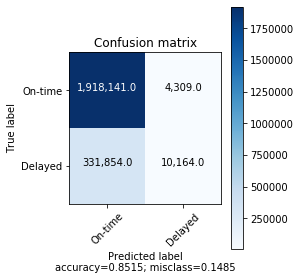

Summary Stats
Precision = 0.7022731983693775
Recall = 0.029717734154342753
F1 Score = 0.05702247742579756
Class 0 precision = 0.852509005575568
Class 0 recall = 0.9977585893001119
Class 0 F1 Measure = 0.919432610855266
Class 1 precision = 0.7022731983693775
Class 1 recall = 0.029717734154342753
Class 1 F1 Measure = 0.05702247742579756
Weighted recall = 0.8515487964502038
Weighted precision = 0.829817870037752
Weighted F(1) Score = 0.7891769441753747
Weighted F(0.5) Score = 0.7646463057433507
Weighted false positive rate = 0.8240724729957492

In [0]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt = GBTClassifier(maxIter = 10, maxDepth = 6, maxBins = 30 )
bestModel = gbt.fit(train)
predictions = predictAndEvaluate(dev, bestModel)

Confusion matrix:
[[1918496. 3954.]
 [ 332041. 9977.]]

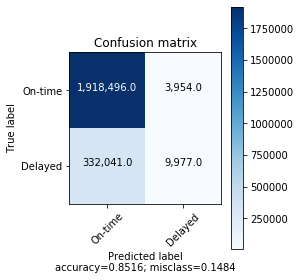

Summary Stats
Precision = 0.7161725647835762
Recall = 0.029170979305182768
F1 Score = 0.056058592663555736
Class 0 precision = 0.8524614347597929
Class 0 recall = 0.9979432494993368
Class 0 F1 Measure = 0.9194833341201399
Class 1 precision = 0.7161725647835762
Class 1 recall = 0.029170979305182768
Class 1 F1 Measure = 0.056058592663555736
Weighted recall = 0.8516229860611852
Weighted precision = 0.8318767999883915
Weighted F(1) Score = 0.7890744242907681
Weighted F(0.5) Score = 0.7643858738247931
Weighted false positive rate = 0.8245087572566656

In [0]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt = GBTClassifier(maxIter = 10, maxDepth = 4, maxBins = 20, stepSize= 0.2 )
bestModel = gbt.fit(train)
predictions = predictAndEvaluate(dev, bestModel)

### 3.1. Using Random Grid Search

We use random grid search to pick from a range of hyper parameters. To reduce the number of grid search combinations we are dealing with and be mindful of not hogging resources on a shared cluster, we employ the following techniques for hyper tuning:

> 1. We only use a fraction of the training data for this task. We use 1% of the training data. This way the code scales down based on the size of the training data. We partition both training and dev datasets with a given ratio such that we maintain the same proportion of labels in both sets
> 2. We use *TrainValidationSplit* instead of *CrossValidation*. It might give us a more approximate results than cross validation but considering the savings on time, especially on a shared cluster, we prefer this option
> 3. To reduce the number of grid searches, we first apply a grid search just for the learning rate and then use the best model  to fine tune the rest of the parameters

In [0]:
ratio = 0.8
def partition(dff, colName, ratio):
    d = dff.sampleBy(colName, fractions={0: ratio, 1: ratio}, seed=SEED)
    return d
  
cvTrainData = partition(train, outcome, 0.01)
cvEvalData = partition(dev, outcome, 0.01)

In [0]:
from pyspark.ml.tuning import ParamGridBuilder
import random

# Random search code
gbt = GBTClassifier(validationTol = 0.01, maxIter = 10)
bEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
randomGrid = (ParamGridBuilder() \
      .addGrid(gbt.stepSize,[x/1000 for x in random.sample(range(1, 250), 6)]) #Pick between 0.001 to 0.25
      .build())

In [0]:
from pyspark.ml.tuning import TrainValidationSplit
import mlflow
import mlflow.spark
tvs = TrainValidationSplit(estimator=gbt, estimatorParamMaps=randomGrid, evaluator = bEvaluator, trainRatio = 0.8, parallelism=4)
model = None
with mlflow.start_run():
  model = tvs.fit(cvTrainData)
  
  # Evaluate the best model's performance on the test dataset and log the result.
  test_metric = bEvaluator.evaluate(model.transform(cvEvalData))
  mlflow.log_metric('val_' + bEvaluator.getMetricName(), test_metric) 

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
model.bestModel.getStepSize()

Out[40]: 0.064

In [0]:
from pyspark.ml.tuning import ParamGridBuilder
import random

# Random search code
gbt = GBTClassifier(validationTol = 0.01, stepSize = 0.064)
bEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
randomGrid = (ParamGridBuilder() \
      .addGrid(gbt.maxIter,random.sample(range(10, 30), 3))
      .addGrid(gbt.maxDepth,random.sample(range(4,8), 3))
      .addGrid(gbt.maxBins, random.sample(range(20, 40), 3))
      .build())
      

In [0]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print(len(randomGrid))
pp.pprint(randomGrid)


27
[ { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 27,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 24,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 27,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 24,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 27,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='max number of iterations (>= 0).'): 12,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20,
 Param(parent='GBTClassifier_47e1546f9f8a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
 { Param(parent='GBTClassifier_47e1546f9f8a', name='maxIter', doc='m

In [0]:
from pyspark.ml.tuning import TrainValidationSplit
import mlflow
import mlflow.spark

tvs = TrainValidationSplit(estimator=gbt, estimatorParamMaps=randomGrid, evaluator = bEvaluator, trainRatio = 0.8, parallelism=8)
# Run TrainValidationSplit, and choose the best set of parameters.
with mlflow.start_run():
  model = tvs.fit(cvTrainData)
  
  # Evaluate the best model's performance on the test dataset and log the result.
  test_metric = bEvaluator.evaluate(model.transform(cvEvalData))

  mlflow.log_metric('val_' + bEvaluator.getMetricName(), test_metric) 

  # Log the best model.
  #mlflow.spark.log_model(spark_model=model.bestModel, artifact_path=f'{save_path}/best-gbt-model') 

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
model.bestModel

Out[44]: GBTClassificationModel: uid = GBTClassifier_47e1546f9f8a, numTrees=14, numClasses=2, numFeatures=161

In [0]:
print(f'maxIter: {model.bestModel.getMaxIter()}')
print(f'maxDepth: {model.bestModel.getMaxDepth()}')
print(f'maxBins: {model.bestModel.getMaxBins()}')

maxIter: 14
maxDepth: 4
maxBins: 27

We retrain the GBTClassifier with all the parameters resulting from our random search so that we can fit the model on the entire training data with these hyper tuned parameters.

Confusion matrix:
[[1918907. 3543.]
 [ 332854. 9164.]]

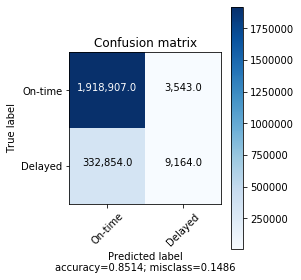

Summary Stats
Precision = 0.7211773038482726
Recall = 0.02679391143156208
F1 Score = 0.05166819367115371
Class 0 precision = 0.8521805822198715
Class 0 recall = 0.9981570391947775
Class 0 F1 Measure = 0.919410638321829
Class 1 precision = 0.7211773038482726
Class 1 recall = 0.02679391143156208
Class 1 F1 Measure = 0.05166819367115371
Weighted recall = 0.8514454609206225
Weighted precision = 0.8323942662895526
Weighted F(1) Score = 0.7883495964194772
Weighted F(0.5) Score = 0.762884791342911
Weighted false positive rate = 0.8264945102942828

In [0]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', 
                    maxIter = 14, #bestModel.getMaxIter, 
                    maxDepth = 4, #bestModel.getMaxDepth, 
                    maxBins = 27 ,
                    stepSize = 0.064)#cvModel.bestModel.getMaxBins) #based on Random/CVgrid search
model = gbt.fit(train)
predictions_gbt = predictAndEvaluate(dev, model)

The results here are an improvement over runs 1 and 2 above, even if it just a small improvement

In [0]:
params = ['maxIter', 'maxDepth', 'maxBins']
paramMap = model.bestModel.extractParamMap()
pp.pprint(paramMap)

{ Param(parent='GBTClassifier_9137a5956009', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0,
 Param(parent='GBTClassifier_9137a5956009', name='validationTol', doc='Threshold for stopping early when fit with validation is used. If the error rate on the validation input changes by less than the validationTol, then learning will stop early (before `maxIter`). This parameter is ignored when fit without validation is used.'): 0.01,
 Param(parent='GBTClassifier_9137a5956009', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1,
 Param(parent='GBTClassifier_9137a5956009', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='GBTClassifier_9137a5956009', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_9137a5956009', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.05,
 Param(parent='GBTClassifier_9137a5956009', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='GBTClassifier_9137a5956009', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1,
 Param(parent='GBTClassifier_9137a5956009', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='GBTClassifier_9137a5956009', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_9137a5956009', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'all',
 Param(parent='GBTClassifier_9137a5956009', name='labelCol', doc='label column name.'): 'label',
 Param(parent='GBTClassifier_9137a5956009', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 69,
 Param(parent='GBTClassifier_9137a5956009', name='maxIter', doc='max number of iterations (>= 0).'): 23,
 Param(parent='GBTClassifier_9137a5956009', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size.'): 256,
 Param(parent='GBTClassifier_9137a5956009', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance',
 Param(parent='GBTClassifier_9137a5956009', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6,
 Param(parent='GBTClassifier_91

### 3.2 Using Cross Validation

We used this method early on in the project on. But because this hogs the cluster, we moved to TrainValidationSplit method instead. I have left this code here just to show how we ran this and demonstrate how we executed this.

In [0]:
def partition(dff, colName, ratio):
    d = dff.sampleBy(colName, fractions={0: ratio, 1: ratio}, seed=SEED)
    return d
  
cvData = partition(dev, outcome, 0.05)
display(cvData)

label features 0.0 Map(vectorType -> sparse, length -> 718, indices -> List(97, 313, 606, 609, 621, 632, 650, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 646.0, 3.708492084973306, 0.7944962089005659, 0.04, 1.0, 21.0, 2.0, 2.0, 2.0, 180.0, 2.6, 61.0, 402.0, 276.9, 275.8, 1012.2, 443.0, 2.1, 61.0, 805.0, 276.3, 275.2, 1011.9, 999.0, 91.0, 805.0, 276.9, 275.8, 1012.3, 374.75, 2.1, 122.0, 2414.0, 277.0, 275.8, 1013.0, 180.0, 1.5, 22000.0, 16093.0, 288.0, 286.3, 1018.6, 200.0, 2.1, 7620.0, 16093.0, 289.1, 286.9, 1018.3, 190.0, 3.6, 7620.0, 16093.0, 290.2, 286.9, 1018.6, 210.0, 2.6, 7620.0, 16093.0, 290.8, 286.9, 1018.9)) 0.0 Map(vectorType -> sparse, length -> 718, indices -> List(0, 399, 606, 608, 616, 638, 650, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 853.0, 0.7944962089005659, 11.910161695841008, 0.005747126436781609, 2.67, 996.0, 2.81, 633.0, 1.94, 300.0, 3.1, 213.0, 16093.0, 290.8, 289.7, 1011.4, 200.0, 6.2, 274.0, 16093.0, 291.9, 290.0, 1010.9, 210.0, 4.6, 274.0, 16093.0, 292.4, 290.8, 1010.9, 200.0, 7.2, 213.0, 6437.0, 292.0, 290.8, 1010.5, 320.0, 6.7, 1524.0, 16093.0, 268.6, 258.6, 1019.2, 310.0, 7.7, 3962.0, 16093.0, 269.1, 259.7, 1018.6, 300.0, 8.2, 3048.0, 16093.0, 270.2, 260.8, 1017.8, 300.0, 6.2, 1829.0, 16093.0, 270.8, 261.9, 1016.1)) 0.0 Map(vectorType -> sparse, length -> 718, indices -> List(0, 462, 606, 611, 617, 642, 650, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 666, 667, 668, 669, 670, 671, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 961.0, 0.5555289667909632, 11.910161695841008, 0.005747126436781609, 2.06, 996.0, 1.0, 174.0, 1.0, 80.0, 3.6, 61.0, 284.7, 284.1, 1020.0, 103.33333333333333, 3.6, 61.0, 284.7, 284.0, 1020.3, 100.0, 3.6, 122.0, 2414.0, 284.7, 283.6, 1020.6, 75.0, 4.1, 122.0, 14236.0, 284.7, 283.6, 1021.5, 170.0, 6.2, 1829.0, 16093.0, 269.1, 257.4, 1015.9, 190.0, 6.2, 2896.0, 16093.0, 269.1, 257.4, 1018.1, 180.0, 6.7, 3658.0, 16093.0, 269.1, 256.9, 1019.6, 190.0, 6.2, 4572.0, 16093.0, 269.1, 255.8, 1022.0)) 0.0 Map(vectorType -> sparse, length -> 718, indices -> List(0, 434, 606, 607, 616, 638, 650, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 106.0, 0.42396602976397224, 11.910161695841008, 0.005747126436781609, 2.75, 996.0, 7.4, 633.0, 3.07, 340.0, 4.1, 366.0, 11265.0, 270.8, 268.0, 1029.5, 340.0, 4.1, 427.0, 16093.0, 270.8, 267.4, 1028.8, 340.0, 5.1, 427.0, 16093.0, 270.8, 266.9, 1027.7, 340.0, 4.1, 488.0, 16093.0, 270.8, 266.9, 1027.7, 15.0, 6.2, 22000.0, 16093.0, 267.4, 262.4, 1032.2, 185.0, 5.7, 701.0, 16093.0, 268.0, 261.9, 1032.4, 355.0, 5.1, 22000.0, 16093.0, 268.0, 262.4, 1031.8, 350.0, 5.7, 701.0, 16093.0, 268.6, 262.4, 1031.9)) 0.0 Map(vectorType -> sparse, length -> 718, indices -> List(0, 315, 606, 611, 616, 640, 650, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 6

In [0]:
cvData.groupBy('label').count().show()

+-----+-----+
label|count|
+-----+-----+
 0.0|11114|
 1.0| 405|
+-----+-----+

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

gbt = GBTClassifier()

# Select hyper parameters
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [4, 6, 8])
             .addGrid(gbt.maxBins, [10, 30, 60])
             .addGrid(gbt.maxIter, [20, 50, 100])
             .build())


evaluator = BinaryClassificationEvaluator()

# Create cross validator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(cvData)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-2158640876510414> in <module> 
 17 
 18 # Run cross validations. This can take about 6 minutes since it is training over 20 trees! 
 ---> 19 cvModel = cv . fit ( dev ) 

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 127 return self . copy ( params ) . _fit ( dataset ) 
 128 else : 
 --> 129 return self . _fit ( dataset ) 
 130 else : 
 131 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/tuning.py in _fit (self, dataset) 
 362 
 363 tasks = _parallelFitTasks ( est , train , eva , validation , epm , collectSubModelsParam ) 
 --> 364 for j , metric , subModel in pool . imap_unordered ( lambda f : f ( ) , tasks ) : 
 365 metrics [ j ] += ( metric / nFolds ) 
 366 metrics_all [ i ] [ j ] = metric

 /databricks/python/lib/python3.7/multiprocessing/pool.py in next (self, timeout) 
 746 if success : 
 747 return value
 --> 748 raise value
 749 
 750 __next__ = next # XXX 

 /databricks/python/lib/python3.7/multiprocessing/pool.py in worker (inqueue, outqueue, initializer, initargs, maxtasks, wrap_exception) 
 119 job , i , func , args , kwds = task
 120 try : 
 --> 121 result = ( True , func ( * args , ** kwds ) ) 
 122 except Exception as e : 
 123 if wrap_exception and func is not _helper_reraises_exception : 

 /databricks/spark/python/pyspark/ml/tuning.py in <lambda> (f) 
 362 
 363 tasks = _parallelFitTasks ( est , train , eva , validation , epm , collectSubModelsParam ) 
 --> 364 for j , metric , subModel in pool . imap_unordered ( lambda f : f ( ) , tasks ) : 
 365 metrics [ j ] += ( metric / nFolds ) 
 366 metrics_all [ i ] [ j ] = metric

 /databricks/spark/python/pyspark/ml/tuning.py in singleTask () 
 52 
 53 def singleTask ( ) : 
 ---> 54 index , model = next ( modelIter ) 
 55 metric = eva . evaluate ( model . transform ( validation , epm [ index ] ) ) 
 56 return index , metric , model if collectSubModel else None 

 /databricks/spark/python/pyspark/ml/base.py in __next__ (self) 
 60 raise StopIteration ( "No models remaining." ) 
 61 self . counter += 1 
 ---> 62 return index , self . fitSingleModel ( index ) 
 63 
 64 def next ( self ) : 

 /databricks/spark/python/pyspark/ml/base.py in fitSingleModel (index) 
 101 
 102 def fitSingleModel ( index ) : 
 --> 103 return estimator . fit ( dataset , paramMaps [ index ] ) 
 104 
 105 return _FitMultipleIterator ( fitSingleModel , len ( paramMaps ) ) 

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 125 elif isinstance ( params , dict ) : 
 126 if params : 
 --> 127 return self . copy ( params ) . _fit ( dataset ) 
 128 else : 
 129 return self . _fit ( dataset ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit (self, dataset) 
 319 
 320 def _fit ( self , dataset ) : 
 --> 321 java_model = self . _fit_java ( dataset ) 
 322 model = self . _create_model ( java_model ) 
 323 return self . _copyValues ( model ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit_java (self, dataset) 
 316 """
 317 self . _transfer_params_to_java ( ) 
 --> 318 return self . _java_obj . fit ( dataset . _jdf ) 
 319 
 320 def _fit ( self , dataset ) : 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 125 def deco ( * a , ** kw ) : 
 126 try : 
 --> 127 return f ( * a , ** kw ) 
 128 except py4j . protocol . Py4JJavaError as e : 
 129 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_

In [0]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{ Param(parent='GBTClassifier_2a44c7a22f2c', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 30,
 Param(parent='GBTClassifier_2a44c7a22f2c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
 Param(parent='GBTClassifier_2a44c7a22f2c', name='maxIter', doc='max number of iterations (>= 0).'): 100}

In [0]:
# Now train a model with the best parameters and evaluate it.
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', 
                    maxIter = 50, #cvModel.bestModel.getMaxIter, 
                    maxDepth = 8, #cvModel.bestModel.getMaxDepth, 
                    maxBins = 30 )#cvModel.bestModel.getMaxBins) #based on CV grid search
model = gbt.fit(train)

predictions_cv = cvModel.transform(test)
evaluateModel(predictions_cv.select('prediction', 'label').rdd.map(tuple), [0,1])

Confusion matrix:
[[246520. 759.]
 [ 5610. 252.]]
Summary Stats
Precision = 0.24925816023738873
Recall = 0.042988741044012284
F1 Score = 0.07333042339589699
Class 0 precision = 0.9777495736326498
Class 0 recall = 0.9969305925695268
Class 0 F1 Measure = 0.987246925866374
Class 1 precision = 0.24925816023738873
Class 1 recall = 0.042988741044012284
Class 1 F1 Measure = 0.07333042339589699
Weighted recall = 0.9748401088721306
Weighted precision = 0.9608798580775915
Weighted F(1) Score = 0.9660833113689914
Weighted F(0.5) Score = 0.9617427156640859
Weighted false positive rate = 0.9349207752585915

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="label")
print("Test Area Under ROC: {}".format(str(evaluator.evaluate(predictions_cv, {evaluator.metricName: "areaUnderROC"}))))
print("Test Area Under PR: {}".format(str(evaluator.evaluate(predictions_cv, {evaluator.metricName: "areaUnderPR"}))))

Test Area Under ROC: 0.7942006972431099
Test Area Under PR: 0.10520536744204301

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol())
rmse = evaluator.evaluate(predictions_cv)
print("RMSE on our test set: %g" % rmse)

RMSE on our test set: 0.158619

In [0]:
model.featureImportances

Out[91]: SparseVector(718, {0: 0.0001, 1: 0.0029, 2: 0.0105, 3: 0.0001, 4: 0.0026, 6: 0.0003, 7: 0.0001, 8: 0.0004, 9: 0.0002, 10: 0.0002, 11: 0.0002, 12: 0.0002, 13: 0.0036, 14: 0.0001, 15: 0.0006, 16: 0.0, 17: 0.0015, 18: 0.0098, 19: 0.0, 20: 0.0011, 21: 0.0012, 22: 0.0001, 23: 0.0013, 24: 0.0001, 25: 0.0, 26: 0.001, 27: 0.0002, 28: 0.0, 29: 0.0003, 30: 0.0002, 31: 0.0, 33: 0.001, 34: 0.0001, 37: 0.0003, 38: 0.0001, 39: 0.0, 40: 0.0001, 42: 0.0001, 43: 0.0, 44: 0.0001, 46: 0.0, 48: 0.0, 49: 0.0002, 51: 0.0001, 52: 0.0001, 53: 0.0003, 55: 0.0001, 59: 0.0001, 60: 0.0001, 62: 0.0002, 63: 0.0002, 66: 0.0001, 67: 0.0001, 69: 0.0002, 72: 0.0001, 74: 0.0, 75: 0.0, 76: 0.0001, 77: 0.0001, 80: 0.0001, 82: 0.0, 85: 0.0001, 86: 0.0001, 87: 0.0002, 89: 0.0002, 94: 0.0005, 95: 0.0001, 97: 0.0001, 98: 0.0, 99: 0.0001, 100: 0.0, 101: 0.0, 104: 0.0001, 106: 0.0, 112: 0.0, 114: 0.0, 115: 0.0001, 117: 0.0001, 118: 0.0001, 121: 0.0001, 126: 0.0001, 127: 0.0001, 128: 0.0001, 130: 0.0, 131: 0.0001, 139: 0.0001, 142: 0.0001, 145: 0.0, 146: 0.0001, 149: 0.0, 154: 0.0, 156: 0.0001, 160: 0.0, 161: 0.0001, 172: 0.0001, 176: 0.0, 179: 0.0, 189: 0.0001, 197: 0.0, 215: 0.0, 216: 0.0, 223: 0.0, 239: 0.0, 250: 0.0001, 259: 0.0003, 260: 0.0001, 281: 0.0001, 283: 0.0001, 302: 0.0019, 303: 0.0068, 304: 0.0005, 305: 0.0001, 306: 0.0008, 307: 0.0, 308: 0.004, 309: 0.0358, 310: 0.0073, 311: 0.0001, 312: 0.0005, 313: 0.0003, 314: 0.0001, 315: 0.0101, 316: 0.0, 317: 0.0003, 318: 0.0074, 319: 0.0069, 320: 0.0101, 323: 0.0001, 324: 0.0001, 325: 0.0006, 326: 0.0001, 327: 0.0, 328: 0.005, 329: 0.0001, 332: 0.0, 333: 0.0, 334: 0.0001, 336: 0.0001, 337: 0.0001, 338: 0.0, 339: 0.0002, 340: 0.0001, 342: 0.0, 343: 0.0001, 348: 0.0001, 350: 0.0, 351: 0.0001, 352: 0.0001, 361: 0.0, 365: 0.0001, 367: 0.0, 369: 0.0001, 370: 0.0001, 374: 0.0004, 375: 0.0001, 378: 0.0001, 379: 0.0002, 380: 0.0, 381: 0.0, 387: 0.0, 388: 0.0001, 390: 0.0001, 391: 0.0, 394: 0.0002, 395: 0.0001, 400: 0.0001, 401: 0.0001, 407: 0.0001, 409: 0.0, 422: 0.0001, 430: 0.0, 437: 0.0001, 438: 0.0002, 439: 0.0001, 441: 0.0001, 444: 0.0, 450: 0.0001, 459: 0.0003, 460: 0.0001, 467: 0.0001, 476: 0.0002, 480: 0.0001, 502: 0.0, 504: 0.0001, 516: 0.0, 519: 0.0, 525: 0.0001, 542: 0.0, 573: 0.0001, 582: 0.0001, 587: 0.0001, 590: 0.0001, 594: 0.0002, 604: 0.0149, 607: 0.0057, 608: 0.0033, 609: 0.0018, 610: 0.0109, 611: 0.0079, 612: 0.0055, 613: 0.0056, 615: 0.0131, 616: 0.0022, 617: 0.0005, 618: 0.0002, 619: 0.0024, 620: 0.0008, 621: 0.0017, 622: 0.0243, 623: 0.0021, 624: 0.0003, 625: 0.0161, 626: 0.0182, 627: 0.0014, 630: 0.0042, 631: 0.0045, 632: 0.002, 633: 0.0008, 634: 0.0021, 635: 0.0015, 636: 0.0031, 637: 0.0003, 638: 0.0037, 639: 0.0006, 640: 0.0005, 641: 0.0014, 642: 0.0018, 643: 0.0033, 644: 0.0008, 645: 0.0012, 646: 0.0004, 647: 0.0009, 650: 0.0076, 653: 0.0123, 654: 0.0136, 655: 0.0047, 656: 0.014, 657: 0.0046, 658: 0.0041, 659: 0.0059, 660: 0.0152, 661: 0.0041, 662: 0.0064, 663: 0.0069, 664: 0.0365, 665: 0.0281, 666: 0.0552, 667: 0.0049, 668: 0.0085, 669: 0.0056, 670: 0.01, 671: 0.0051, 672: 0.0155, 673: 0.0038, 674: 0.0028, 675: 0.0067, 676: 0.0052, 677: 0.0089, 678: 0.0084, 679: 0.0153, 680: 0.0048, 681: 0.0063, 682: 0.006, 683: 0.0059, 684: 0.012, 685: 0.0086, 686: 0.0063, 687: 0.0078, 688: 0.0093, 689: 0.0073, 690: 0.0133, 691: 0.0208, 692: 0.036, 693: 0.0214, 694: 0.0158, 695: 0.0119, 696: 0.0056, 697: 0.0049, 698: 0.0157, 699: 0.0077, 700: 0.0087, 701: 0.0026, 702: 0.0076, 703: 0.0055, 704: 0.0049, 705: 0.0052, 706: 0.0059, 707: 0.0073, 708: 0.0051, 709: 0.0079, 710: 0.0041, 711: 0.0077, 712: 0.01, 713: 0.0089, 714: 0.0092, 715: 0.0128, 716: 0.004, 717: 0.0122})

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema["features"].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
ExtractFeatureImp(model.featureImportances, train, "features").head(50)

Out[90]:

idx 
 name 
 score 
 
 
 
 
 13 
 666 
 origin_2_temperature_Vect_origin_2_temperature... 
 0.055175 
 
 
 11 
 664 
 origin_2_ceiling_Vect_origin_2_ceiling_Imputed 
 0.036526 
 
 
 39 
 692 
 destination_2_ceiling_Vect_destination_2_ceili... 
 0.036035 
 
 
 374 
 309 
 destinationclassVec_SFO 
 0.035845 
 
 
 12 
 665 
 origin_2_visibility_Vect_origin_2_visibility_I... 
 0.028095 
 
 
 687 
 622 
 op_carrierclassVec_MQ 
 0.024257 
 
 
 40 
 693 
 destination_2_visibility_Vect_destination_2_vi... 
 0.021367 
 
 
 38 
 691 
 destination_2_wind_speed_Vect_destination_2_wi... 
 0.020808 
 
 
 691 
 626 
 op_carrierclassVec_F9 
 0.018157 
 
 
 690 
 625 
 op_carrierclassVec_NK 
 0.016082 
 
 
 41 
 694 
 destination_2_temperature_Vect_destination_2_t... 
 0.015847 
 
 
 45 
 698 
 destination_3_wind_speed_Vect_destination_3_wi... 
 0.015667 
 
 
 19 
 672 
 origin_3_visibility_Vect_origin_3_visibility_I... 
 0.015482 
 
 
 26 
 679 
 origin_4_visibility_Vect_origin_4_visibility_I... 
 0.015267 
 
 
 7 
 660 
 avg_car_per_day_Vect_avg_car_per_day_Imputed 
 0.015206 
 
 
 669 
 604 
 monthclassVec_1 
 0.014881 
 
 
 3 
 656 
 weight_Vect_weight_Imputed 
 0.013977 
 
 
 1 
 654 
 dest_pagerank_Vect_dest_pagerank_Imputed 
 0.013611 
 
 
 37 
 690 
 destination_2_wind_angle_Vect_destination_2_wi... 
 0.013283 
 
 
 680 
 615 
 op_carrierclassVec_WN 
 0.013130 
 
 
 62 
 715 
 destination_5_temperature_Vect_destination_5_t... 
 0.012803 
 
 
 0 
 653 
 distance_Vect_distance_Imputed 
 0.012319 
 
 
 64 
 717 
 destination_5_pressure_Vect_destination_5_pres... 
 0.012237 
 
 
 31 
 684 
 origin_5_wind_speed_Vect_origin_5_wind_speed_I... 
 0.012012 
 
 
 42 
 695 
 destination_2_dewpoint_Vect_destination_2_dewp... 
 0.011894 
 
 
 675 
 610 
 day_of_weekclassVec_1 
 0.010924 
 
 
 67 
 2 
 originclassVec_DFW 
 0.010453 
 
 
 380 
 315 
 destinationclassVec_LGA 
 0.010134 
 
 
 385 
 320 
 destinationclassVec_JFK 
 0.010106 
 
 
 59 
 712 
 destination_5_wind_speed_Vect_destination_5_wi... 
 0.010043 
 
 
 17 
 670 
 origin_3_wind_speed_Vect_origin_3_wind_speed_I... 
 0.010000 
 
 
 83 
 18 
 originclassVec_JFK 
 0.009807 
 
 
 35 
 688 
 origin_5_dewpoint_Vect_origin_5_dewpoint_Imputed 
 0.009336 
 
 
 61 
 714 
 destination_5_visibility_Vect_destination_5_vi... 
 0.009187 
 
 
 60 
 713 
 destination_5_ceiling_Vect_destination_5_ceili... 
 0.008918 
 
 
 24 
 677 
 origin_4_wind_speed_Vect_origin_4_wind_speed_I... 
 0.008897 
 
 
 47 
 700 
 destination_3_visibility_Vect_destination_3_vi... 
 0.008740 
 
 
 32 
 685 
 origin_5_ceiling_Vect_origin_5_ceiling_Imputed 
 0.008560 
 
 
 15 
 668 
 origin_2_pressure_Vect_origin_2_pressure_Imputed 
 0.008459 
 
 
 25 
 678 
 origin_4_ceiling_Vect_origin_4_ceiling_Imputed 
 0.008441 
 
 
 676 
 611 
 day_of_weekclassVec_2 
 0.007924 
 
 
 56 
 709 
 destination_4_dewpoint_Vect_destination_4_dewp... 
 0.007879 
 
 
 34 
 687 
 origin_5_temperature_Vect_origin_5_temperature... 
 0.007835 
 
 
 58 
 711 
 destination_5_wind_angle_Vect_destination_5_wi... 
 0.007690 
 
 
 46 
 699 
 destination_3_ceiling_Vect_destination_3_ceili... 
 0.007652 
 
 
 49 
 702 
 destination_3_dewpoint_Vect_destination_3_dewp... 
 0.007567 
 
 
 715 
 650 
 equipment_delayedclassVec_0 
 0.007554 
 
 
 383 
 318 
 destinationclassVec_EWR 
 0.007411 
 
 
 36 
 689 
 origin_5_pressure_Vect_origin_5_pressure_Imputed 
 0.007321 
 
 
 375 
 310 
 destinationclassVec_LAS 
 0.007289